In [1]:
from librosa import load
from soundfile import write
from scipy.signal import butter, lfilter
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
working_dir = os.getcwd()
speaker = 'Speaker_8'

### Visualization of signal

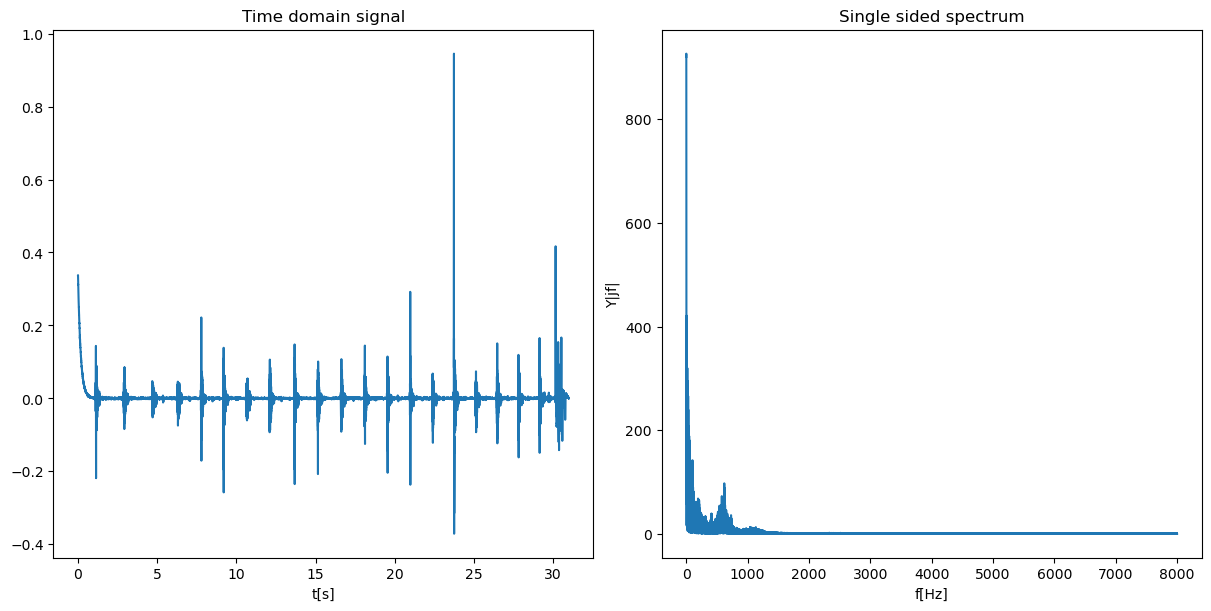

In [3]:
y, fs = load(os.path.join(working_dir, '..', 'Data', speaker+'.wav'), sr=None)
duration = len(y)/fs
N = len(y)
t = np.linspace(0,duration,N)

Y = abs(np.fft.fft(y,N))
Y = Y[0:N//2]
f = np.fft.fftfreq(n = N, d = 1/fs)
f = f[0:N//2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6),
                       layout='constrained')
axs = ax.ravel()
axs[0].plot(t,y)
axs[0].title.set_text('Time domain signal')
axs[0].set_xlabel('t[s]')
axs[1].plot(f,Y)
axs[1].title.set_text('Single sided spectrum')
axs[1].set_xlabel('f[Hz]')
axs[1].set_ylabel('Y|jf|')

plt.show()


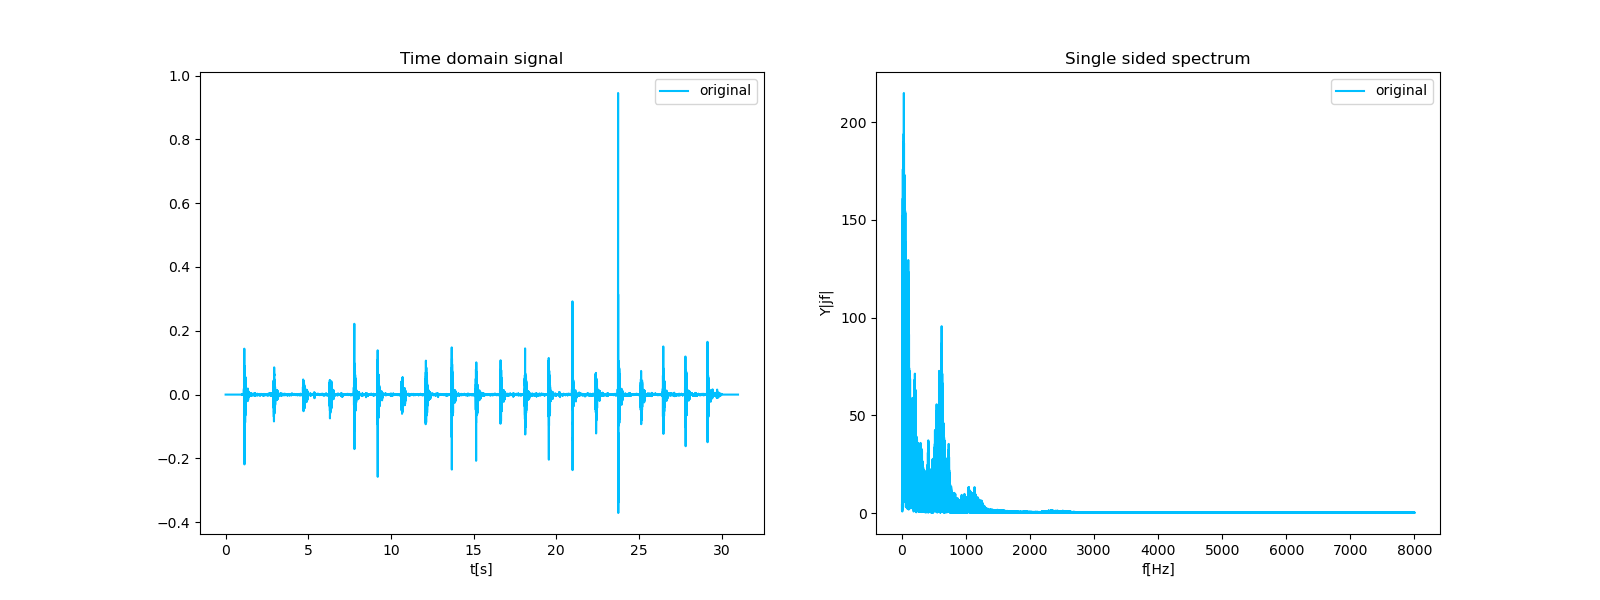

In [39]:
y[:int(1*fs)] = 0
y[int(30*fs):] = 0

Y = abs(np.fft.fft(y,N))
Y = Y[0:N//2]
f = np.fft.fftfreq(n = N, d = 1/fs)
f = f[0:N//2]

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(t,y,color='deepskyblue', label='original')
plt.title('Time domain signal')
plt.xlabel('t[s]')
plt.legend()

plt.subplot(122)
plt.plot(f,Y, color = 'deepskyblue', label='original')
plt.title('Single sided spectrum')
plt.xlabel('f[Hz]')
plt.ylabel('Y|jf|')
plt.legend()
plt.show()

### Filtering

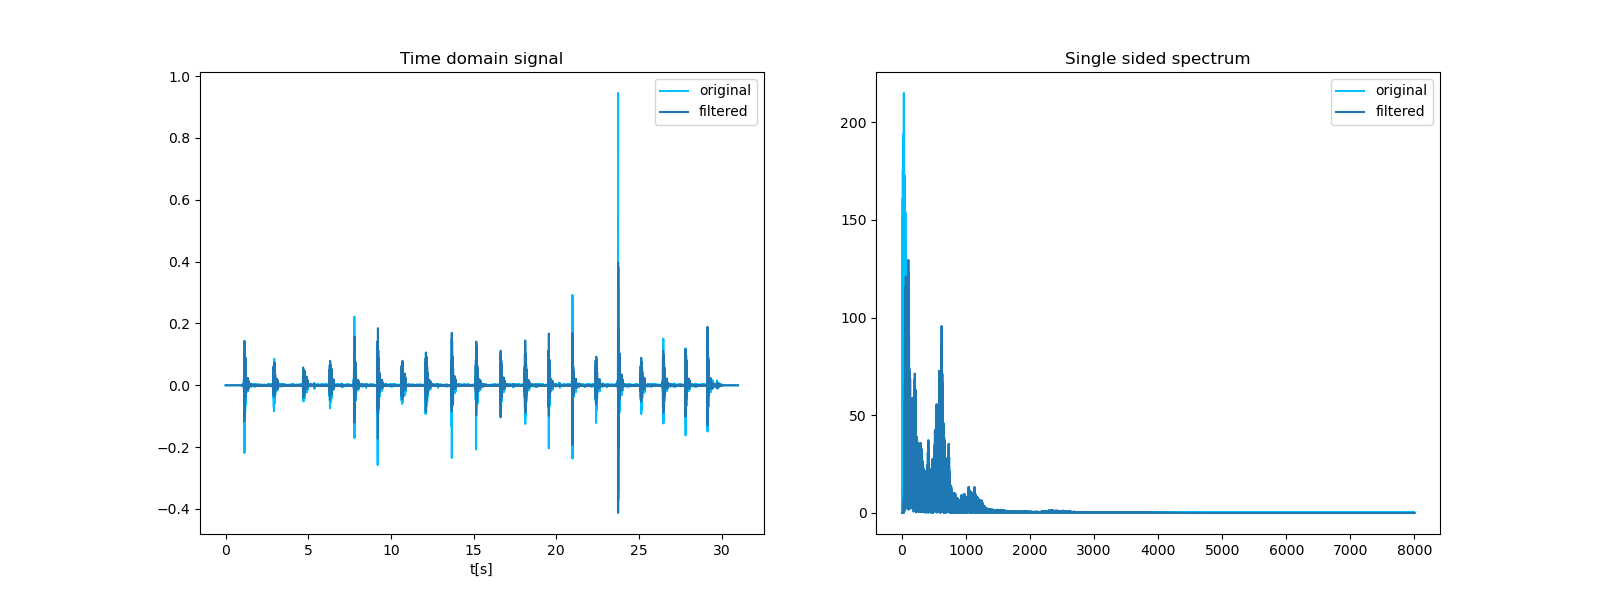

In [38]:
Wn = np.array([50/(fs/2), 3500/(fs/2)])
B,A = butter(6, Wn, btype='bandpass')
yf = lfilter(B,A,y)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(t,y,color='deepskyblue', label='original')
plt.plot(t, yf, label='filtered')
plt.title('Time domain signal')
plt.xlabel('t[s]')
plt.legend()

Yf = abs(np.fft.fft(yf,N))
Yf = Yf[0:N//2]

plt.subplot(122)
plt.plot(f,Y, color = 'deepskyblue', label='original')
plt.plot(f,Yf,label='filtered')
plt.title('Single sided spectrum')
plt.legend()
plt.show()

### Choosing a window function

In [6]:
wl = np.array(np.multiply([1e-3,10e-3, 20e-3, 50e-3],fs), dtype=int)
E = np.zeros(len(yf))
time = np.arange(0,E.shape[0]/fs,1/fs)
'''
colors = ['lightcoral', 'indianred', 'firebrick', 'maroon']
fig,ax = plt.subplots()
for i in range(len(wl)):
    for k in range(i,len(yf)):
        rng = np.arange((k-wl[i]),k)
        E[k] = np.sum(np.power(yf[rng],2))
    ax.plot(time,E, color=colors[i],label=str(wl[i]/fs)+'s')
ax.legend()
plt.show()
'''

"\ncolors = ['lightcoral', 'indianred', 'firebrick', 'maroon']\nfig,ax = plt.subplots()\nfor i in range(len(wl)):\n    for k in range(i,len(yf)):\n        rng = np.arange((k-wl[i]),k)\n        E[k] = np.sum(np.power(yf[rng],2))\n    ax.plot(time,E, color=colors[i],label=str(wl[i]/fs)+'s')\nax.legend()\nplt.show()\n"

### Short time energy and zero crossing rate with 20ms window

In [40]:
wl = int(fs*20e-3)
E = np.zeros(len(yf))
ZCR = np.zeros(len(yf))

for i in range(wl, len(yf)):
    rng = np.arange(i-wl, i)
    E[i] = np.sum(np.power(yf[rng],2))
    ZCR[i] = np.sum(np.abs(np.sign(yf[rng+1])-np.sign(yf[rng])))
ZCR = ZCR/2/wl

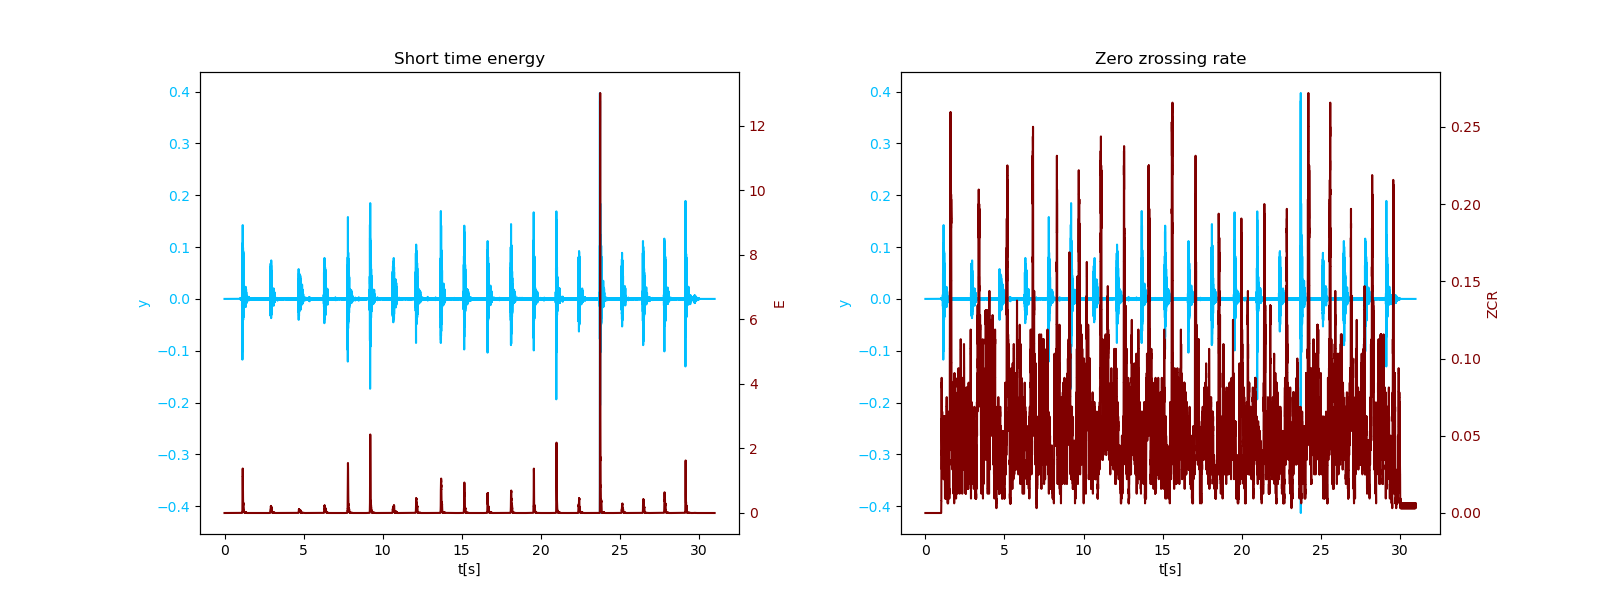

In [41]:
fig,(axs_left_1, axs_left_2) = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
plt.subplots_adjust(wspace=0.3)

axs_left_1.title.set_text('Short time energy')
axs_left_1.plot(time, yf, color = 'deepskyblue')
axs_left_1.set_ylabel('y', color='deepskyblue')
axs_left_1.set_xlabel('t[s]')
axs_left_1.tick_params(axis='y', labelcolor='deepskyblue')


axs_right_1 = axs_left_1.twinx()
axs_right_1.set_ylabel('E', color='maroon')
axs_right_1.plot(time,E, color='maroon')
axs_right_1.tick_params(axis='y', labelcolor='maroon')

axs_left_2.title.set_text('Zero zrossing rate')
axs_left_2.plot(time, yf, color = 'deepskyblue')
axs_left_2.set_ylabel('y', color='deepskyblue')
axs_left_2.set_xlabel('t[s]')
axs_left_2.tick_params(axis='y', labelcolor='deepskyblue')


axs_right_2 = axs_left_2.twinx()
axs_right_2.set_ylabel('ZCR', color='maroon')
axs_right_2.plot(time,ZCR, color='maroon')
axs_right_2.tick_params(axis='y', labelcolor='maroon')

plt.show()

### Word segmentation

#### Short time energy

In [62]:
%matplotlib widget
ITU = 0.001*np.max(E)
ITL = 0.000009*max(E)

##### Finding begginings and ends of words with upper threshold

In [63]:
word_beginning = []
word_end = []

for i in range(1, E.shape[0]):
    if (E[i-1] < ITU) and (E[i] >= ITU):
        word_beginning.append(i)
    elif (E[i-1] > ITU) and (E[i] <= ITU):
        word_end.append(i)


In [64]:
word = np.zeros(shape = E.shape)
for i in range(len(word_beginning)):
    word[word_beginning[i]:word_end[i]] = max(E)/10*np.ones(word_end[i]-word_beginning[i])

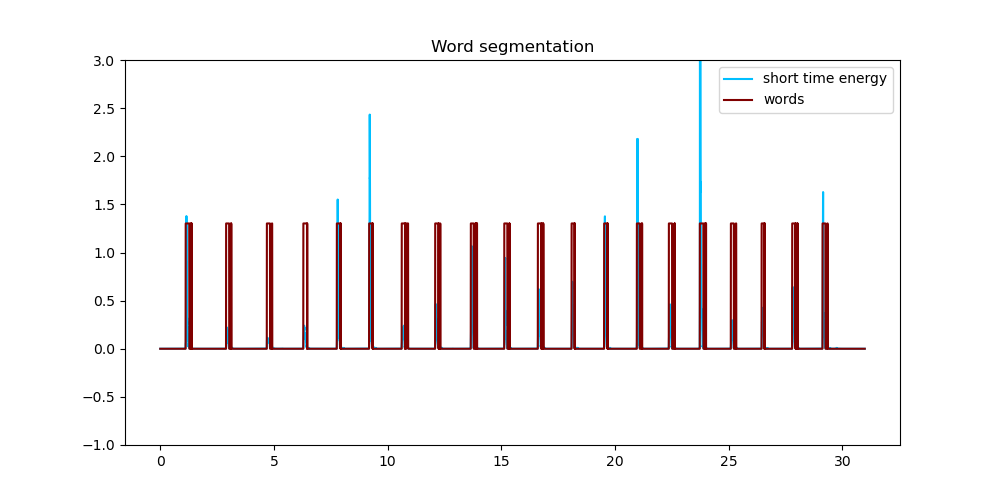

In [65]:
fig = plt.figure(figsize=(10,5))
plt.title("Word segmentation")
plt.plot(time, E, color='deepskyblue', label="short time energy")
plt.plot(time, word, color='maroon', label='words')
ax = plt.axis()
ax = [ax[0], ax[1], -1, 3]
plt.axis(ax)
plt.legend()
plt.show()

##### Refining our search with lower threshold

In [66]:
for i in range(len(word_beginning)):
    new_beginning = word_beginning[i]
    while(E[new_beginning] > ITL):
        new_beginning -= 1
    word_beginning[i] = new_beginning

for i in range(len(word_end)):
    new_end = word_end[i]
    while(E[new_end] > ITL):
        new_end += 1
    word_end[i] = new_end

word_beginning = list(dict.fromkeys(word_beginning))
word_end = list(dict.fromkeys(word_end))

In [67]:
word = np.zeros(shape = E.shape)
word_dict = {}
for i in range(len(word_beginning)):
    word[word_beginning[i]:word_end[i]] = max(E)/10*np.ones(word_end[i]-word_beginning[i])
    word_dict[i] = y[word_beginning[i]:word_end[i]]

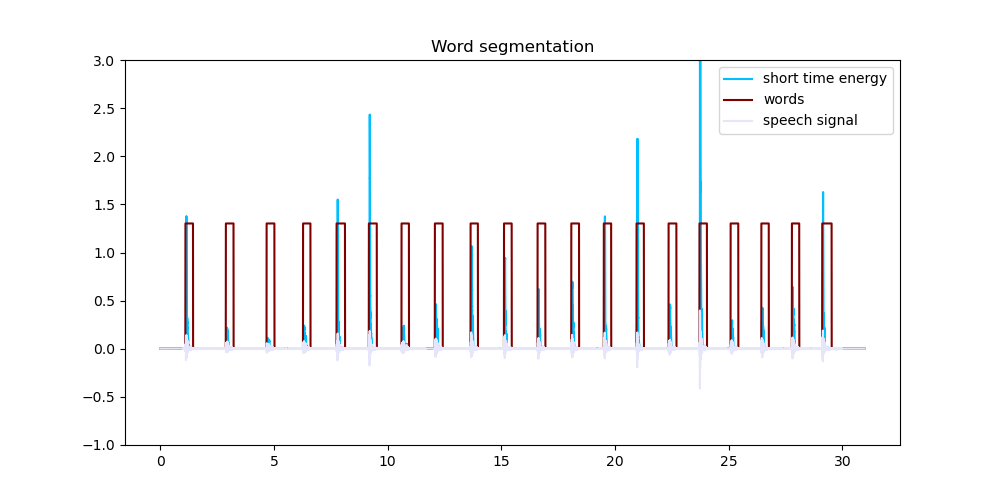

In [68]:
fig = plt.figure(figsize=(10,5))
plt.title("Word segmentation")
plt.plot(time, E, color='deepskyblue', label="short time energy")
plt.plot(time, word, color='maroon', label='words')
plt.plot(time, yf, color="lavender", label='speech signal')
ax = plt.axis()
ax = [ax[0], ax[1], -1, 3]
plt.axis(ax)
plt.legend()
plt.show()

#### Zero crossing rate

In [79]:
IZCT = 50
frames = 35
threshold = 3
#---------------------------------

#Finding new beginnings
for i in range(len(word_beginning)):
    j = wl
    flags = 0
    first_flag_frame = 0
    while(j<=frames*wl):
        if(np.any(ZCR[word_beginning[i]-j:word_beginning[i]]*2*wl > IZCT)):
            flags = flags+1
            if flags == 0:
                first_flag_frame = j
        if flags>=threshold:
            word_beginning[i] = word_beginning[i]-first_flag_frame
            break
        j = j+wl
    
# Finding new ends
for i in range(len(word_end)):
    j = 0
    flags = 0
    first_flag_frame = 0
    while(j<=frames*wl):
        if(np.any(ZCR[word_end[i]:word_end[i]+j]*2*wl > IZCT)):
            flags = flags+1
            if flags == 0:
                first_flag_frame = j
            if flags>=threshold:
               word_end[i] = word_end[i]+first_flag_frame
               break
        j = j+1
#---------------------------------

In [80]:
word_beginning = list(dict.fromkeys(word_beginning))
word_end = list(dict.fromkeys(word_end))

word = np.zeros(shape = E.shape)
word_dict = {}
for i in range(len(word_beginning)):
    word[word_beginning[i]:word_end[i]] = max(yf)*np.ones(word_end[i]-word_beginning[i])
    word_dict[i] = y[word_beginning[i]:word_end[i]]

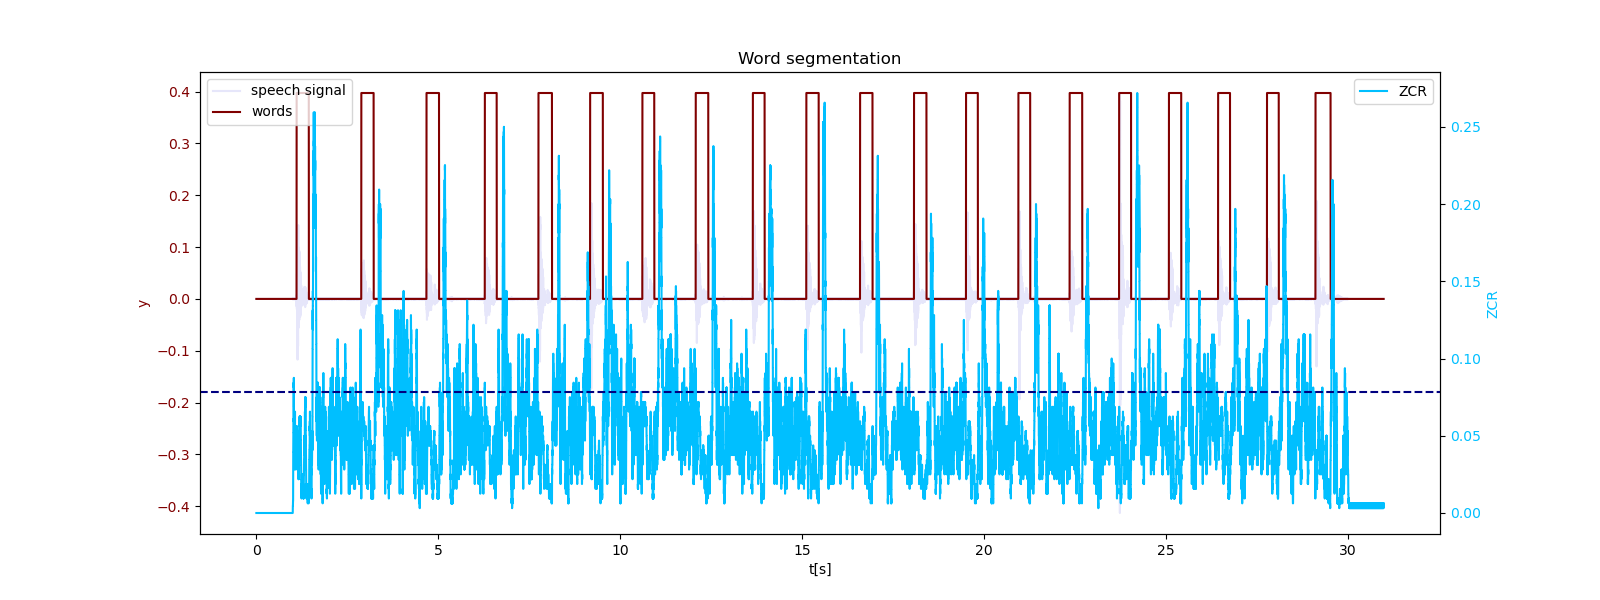

In [81]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.title.set_text("Word segmentation")
ax.plot(time, yf, color="lavender", label='speech signal')
ax.plot(time, word, color='maroon', label='words')
ax.set_xlabel('t[s]')
ax.set_ylabel('y', color='maroon')
ax.tick_params(axis='y', labelcolor='maroon')
ax.legend(loc='upper left')

ax_right = ax.twinx()
ax_right.plot(time, ZCR, color='deepskyblue', label="ZCR")
ax_right.axhline(IZCT/2/wl, color='navy', linestyle='dashed')
ax_right.set_ylabel('ZCR', color='deepskyblue')
ax_right.tick_params(axis='y', labelcolor='deepskyblue')
ax_right.legend()
plt.show()

### Visualize and save words to separate audio files

##### Visualize all words separately

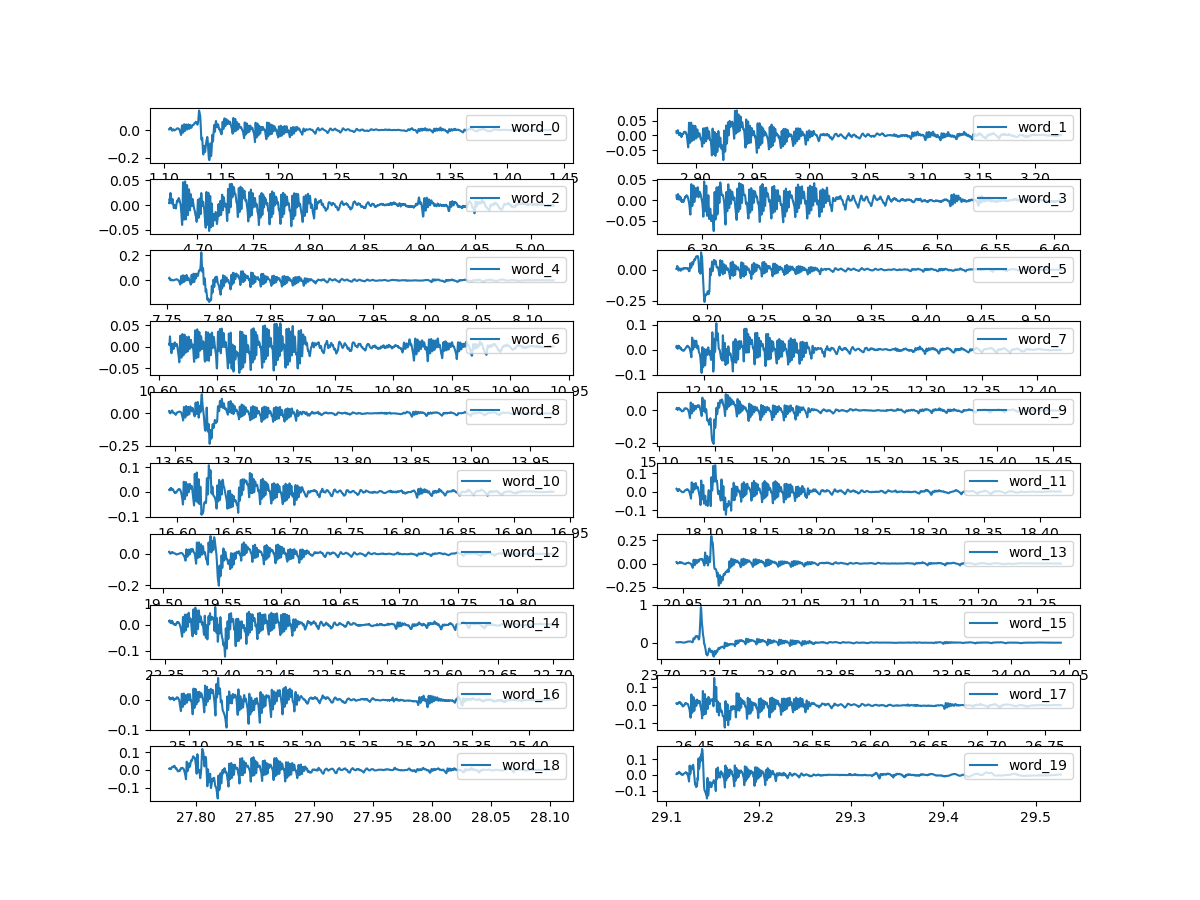

In [82]:
fig, ax = plt.subplots(figsize=(12,9),nrows=-(len(word_dict.keys())//-2), ncols=2)
fig.subplots_adjust(hspace=0.3)
axs = ax.ravel()
if len(word_dict.keys())%2 == 1:
    axs[-1].set_visible(False)

for i in word_dict.keys():
    axs[i].plot(time[word_beginning[i]:word_end[i]], word_dict[i], label="word_{}".format(i))
    axs[i].legend(loc="upper right")
plt.show()


##### Save audio files

In [42]:
#for i in word_dict.keys():
 #  write(os.path.join(working_dir,'..', 'Data', 'words', speaker,'word_{}.wav'.format(i)), data=word_dict[i], samplerate=fs)